<a href="https://colab.research.google.com/github/zwubbena/sample-size-tables/blob/main/systemic_sample_size_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Systemic Sample Size Generator (Cap 12)  
**Anchored to approved Primary (Post-hoc) Sample Size Table (Cap 16)**

**Goal.** Generate a statistically justified *systemic* sample size table for special education monitoring noncompliance verification:  

![systemic_formula](https://latex.codecogs.com/svg.latex?n_%7B%5Ctext%7Bsystemic%7D%7D%28N%29%20%3D%20%5Cmin%5Cleft%2812%2C%20%5Clceil%200.75%20%5Ccdot%20n_%7B%5Ctext%7Bprimary%7D%7D%28N%29%20%5Crceil%20%5Cright%29)

…where ![n_primary](https://latex.codecogs.com/svg.latex?n_%7B%5Ctext%7Bprimary%7D%7D%28N%29) comes from the approved post-hoc table (cap 16).  

---

**Why 0.75?** Preserves the legacy ratio (systemic:max 18 vs primary:max 24 → 18/24 = 0.75), giving a predictable **~15%** MOE relaxation:  

![MOE ratio](https://latex.codecogs.com/svg.latex?%5Cfrac%7BMOE_%7Bsys%7D%7D%7BMOE_%7Bprim%7D%7D%20%5Capprox%20%5Csqrt%7B1/0.75%7D%20%5Capprox%201.155)

---

**This notebook outputs:**
- Primary reference table (cap 16)  
- Systemic mapping by primary n  
- Production rubric by LEA bands (evaluated at band upper bounds)  
- Figures: step curves + MOE ratio  
- Excel workbook with all tables + embedded figures

---

**This notebook outputs:**
- Primary reference table (cap 16)  
- Systemic mapping by primary n  
- Production rubric by LEA bands (evaluated at band upper bounds)  
- Figures: step curves + MOE ratio  
- Excel workbook with all tables + embedded figures  

---

## Production-Ready Systemic Sample Size Rubric

| Band (LEA SPED Population) | Primary n <br>(cap 16) | Systemic n <br>(cap 12) | Requirement |
|-----------------------------|------------------------|--------------------------|-------------|
| **<50** <br> (~425 LEAs)    | 12                     | **9**                    | Evidence of correction must be submitted for up to **9** students. <br><br>*If the LEA has RF students: ensure that 1–2 RF student folders are reviewed as part of this submission.* |
| **50–100** <br> (~280 LEAs) | 14                     | **11**                   | Evidence of correction must be submitted for **11** students. <br><br>*If the LEA has RF students: ensure that 1–2 RF student folders are reviewed as part of this submission.* |
| **101–500** <br> (~340 LEAs)| 16                     | **12**                   | Evidence of correction must be submitted for **12** students. <br><br>*If the LEA has RF students: ensure that 2–3 RF student folders are reviewed as part of this submission.* |
| **501–1500** <br> (~100 LEAs)| 16                    | **12**                   | Evidence of correction must be submitted for **12** students. <br><br>*If the LEA has RF students: ensure that 2–3 RF student folders are reviewed as part of this submission.* |
| **>1500** <br> (~70 LEAs)   | 16                     | **12**                   | Evidence of correction must be submitted for **12** students. <br><br>*If the LEA has RF students: ensure that 5 RF student folders are reviewed as part of this submission.* |

---

**Footnote:**  
If the calculated systemic sample size is fewer than **9**, the LEA must conduct a **full census** of all student folders.  

---

## Systemic Sample Size Quick Reference (Numeric Only)

| Band (LEA SPED Population) | Primary n (cap 16) | Systemic n (cap 12) |
|-----------------------------|--------------------|----------------------|
| **<9 students**             | Census             | Census *(all folders reviewed)* |
| **9–49**                    | 12                 | 9                    |
| **50–100**                  | 14                 | 11                   |
| **101–500**                 | 16                 | 12                   |
| **501–1500**                | 16                 | 12                   |
| **>1500**                   | 16                 | 12                   |

---

**Footnote:**  
- If an LEA has fewer than **9 students** in special education, both the **primary** and **systemic** requirements default to a **full census**.  
- For all other bands, the systemic sample size is calculated as  
  ![systemic_formula](https://latex.codecogs.com/svg.latex?n_%7B%5Ctext%7Bsystemic%7D%7D%28N%29%20%3D%20%5Cmin%2812%2C%5Clceil0.75%5Ccdot%20n_%7B%5Ctext%7Bprimary%7D%7D%28N%29%5Crceil%29).  

---

In [1]:
# Parameters and helper functions

import math, io
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Parameters (edit if policy changes) ===
RATIO_SYSTEMIC = 0.75          # systemic = ceil(0.75 * primary)
PRIMARY_CAP    = 16            # approved cap from post-hoc table
SYSTEMIC_CAP   = math.ceil(RATIO_SYSTEMIC * PRIMARY_CAP)  # -> 12
Z              = 1.96          # ref only; cancels in MOE ratio
P              = 0.5           # ref only; cancels in MOE ratio

# Production rubric bands (for communications)
RUBRIC_BANDS = [
    {"label": "<50",     "lo": 1,    "hi": 49,    "evalN": 49},
    {"label": "50–100",  "lo": 50,   "hi": 100,   "evalN": 100},
    {"label": "101–500", "lo": 101,  "hi": 500,   "evalN": 500},
    {"label": "501–1500","lo": 501,  "hi": 1500,  "evalN": 1500},
    {"label": ">1500",   "lo": 1501, "hi": None,  "evalN": 2000},  # conservative large-N
]

# Approved Primary (post-hoc) table as stepwise ranges -> n (cap 16)
PRIMARY_TABLE_RANGES = [
    {"lo": 1,   "hi": 1,    "n": 1},
    {"lo": 2,   "hi": 3,    "n": 2},
    {"lo": 4,   "hi": 6,    "n": 4},
    {"lo": 7,   "hi": 11,   "n": 6},
    {"lo": 12,  "hi": 19,   "n": 8},
    {"lo": 20,  "hi": 32,   "n": 10},
    {"lo": 33,  "hi": 64,   "n": 12},
    {"lo": 65,  "hi": 224,  "n": 14},
    {"lo": 225, "hi": None, "n": 16},  # 225+
]

def primary_n_for_N(N: int) -> int:
    """Look up primary sample size for population N."""
    for row in PRIMARY_TABLE_RANGES:
        lo, hi, n = row["lo"], row["hi"], row["n"]
        if hi is None:
            if N >= lo:
                return n
        else:
            if lo <= N <= hi:
                return n
    return PRIMARY_CAP  # fallback

def systemic_n_from_primary(n_primary: int) -> int:
    """Apply systemic rule and cap."""
    return min(math.ceil(RATIO_SYSTEMIC * n_primary), SYSTEMIC_CAP)

def moe_ratio(N: int, n_primary: int, n_systemic: int) -> float:
    """
    MOE_systemic / MOE_primary under SRS with FPC.
    MOE ~ sqrt(p(1-p)/n) * sqrt((N-n)/(N-1)) * Z  -> constants cancel in ratio.
    """
    if n_systemic <= 0 or (N - n_primary) <= 0:
        return float("nan")
    return float(
        math.sqrt(n_primary / n_systemic) *
        math.sqrt((N - n_systemic) / (N - n_primary))
    )

### 2. Primary reference table (cap = 16)

The primary table is derived from the finite-population sample size formula:
![n formula](https://latex.codecogs.com/svg.latex?n%20=%20%5Cfrac%7BNZ%5E2p%281-p%29%7D%7B%28N-1%29e%5E2%20+%20Z%5E2p%281-p%29%7D)
…then published as the stepwise ranges below (cap 16).


In [2]:
primary_ref_df = pd.DataFrame([
    {"Primary Sample Size": r["n"],
     "Population (N)": f"{r['lo']}+" if r["hi"] is None else f"{r['lo']}-{r['hi']}"}
    for r in PRIMARY_TABLE_RANGES
])
primary_ref_df


,Primary Sample Size,Population (N)
0,1,1-1
1,2,2-3
2,4,4-6
3,6,7-11
4,8,12-19
5,10,20-32
6,12,33-64
7,14,65-224
8,16,225+


### 3. Systemic rule and mapping

We preserve the legacy 0.75 ratio and round up:
![systemic](https://latex.codecogs.com/svg.latex?n_%7Bsys%7D%28N%29%20=%20%5Cmin%2812,%20%5Clceil0.75%20%5Ccdot%20n_%7Bprimary%7D%28N%29%5Crceil%29)


In [3]:
primary_values = sorted({r["n"] for r in PRIMARY_TABLE_RANGES})
systemic_map_df = pd.DataFrame({
    "Primary n": primary_values,
    "Systemic n = ceil(0.75 × n) (cap 12)": [systemic_n_from_primary(n) for n in primary_values]
})
systemic_map_df


,Primary n,Systemic n = ceil(0.75 × n) (cap 12)
0,1,1
1,2,2
2,4,3
3,6,5
4,8,6
5,10,8
6,12,9
7,14,11
8,16,12


### 4. Production-ready systemic rubric (evaluated at band upper bounds)

For communications, we publish by LEA bands. We conservatively evaluate at each band’s upper bound to assign the systemic sample size.


In [4]:
rubric_rows = []
for band in RUBRIC_BANDS:
    N_eval = band["evalN"]
    n_p = primary_n_for_N(N_eval)
    n_s = systemic_n_from_primary(n_p)
    rubric_rows.append({
        "LEA SPED Population Band": band["label"],
        "Evaluated at N": N_eval,
        "Primary n": n_p,
        "Systemic n (cap 12)": n_s
    })
rubric_df = pd.DataFrame(rubric_rows)
rubric_df


,LEA SPED Population Band,Evaluated at N,Primary n,Systemic n (cap 12)
0,<50,49,12,9
1,50–100,100,14,11
2,101–500,500,16,12
3,501–1500,1500,16,12
4,>1500,2000,16,12


### 5. Visualizations

5.1. **Step functions (Primary vs Systemic sample sizes)**  

This graph shows the relationship between population size (*N*) and required sample sizes under the two rules:  

- **Primary** sample size: capped at 16 under the approved post-hoc table.  
- **Systemic** sample size: defined as  

![systemic_formula](https://latex.codecogs.com/svg.latex?n_%7B%5Ctext%7Bsystemic%7D%7D%28N%29%20%3D%20%5Cmin%5Cleft%2812%2C%20%5Clceil%200.75%20%5Ccdot%20n_%7B%5Ctext%7Bprimary%7D%7D%28N%29%20%5Crceil%20%5Cright%29)  

**How to interpret the graph:**  
- The **blue step line** shows how the primary sample size increases in steps, reaching a maximum of 16.  
- The **orange step line** shows the systemic sample size, always at ~75% of the primary, capped at 12.  
- For small LEAs, the systemic line mirrors the shape of the primary line but at lower values.  
- For large LEAs, the systemic size flattens at 12, while the primary stays at 16.  
- This visualization highlights the **burden reduction**: systemic draws are consistently smaller, especially for larger LEAs.  

---

5.2. **Precision impact (MOE ratio curve)**  

This graph shows the change in precision when reducing the sample size from primary to systemic. The ratio is:  

![moe_ratio](https://latex.codecogs.com/svg.latex?%5Cfrac%7BMOE_%7Bsys%7D%7D%7BMOE_%7Bprim%7D%7D%20%3D%20%5Csqrt%7B%5Cfrac%7Bn_%7Bprim%7D%7D%7Bn_%7Bsys%7D%7D%7D%20%5Ctimes%20%5Csqrt%7B%5Cfrac%7BN-n_%7Bsys%7D%7D%7BN-n_%7Bprim%7D%7D%7D)  

For large *N*, this approaches:  

![limit](https://latex.codecogs.com/svg.latex?%5Csqrt%7B1/0.75%7D%20%5Capprox%201.155)  

**How to interpret the graph:**  
- The **y-axis** is the ratio of systemic MOE to primary MOE. That is, the **y-axis** shows how much larger the systemic MOE is compared to the primary MOE.  
- A value of **1.0** would mean no loss of precision.  
- The curve stabilizes around **1.15**, meaning systemic sampling has about **15% more margin of error** than primary.  
- For both small and large LEAs, the increase in MOE remains stable and predictable.
- For **small LEAs**, the ratio briefly wavers but quickly stabilizes.  
- For **large LEAs**, the ratio holds steady, demonstrating predictable and uniform precision reduction.    
- This shows that although precision is slightly reduced, it is **uniform and acceptable** across all population sizes, which means the tradeoff is **consistent and controlled**—precision loss is modest, capped at ~15%, while sample sizes shrink substantially.




0

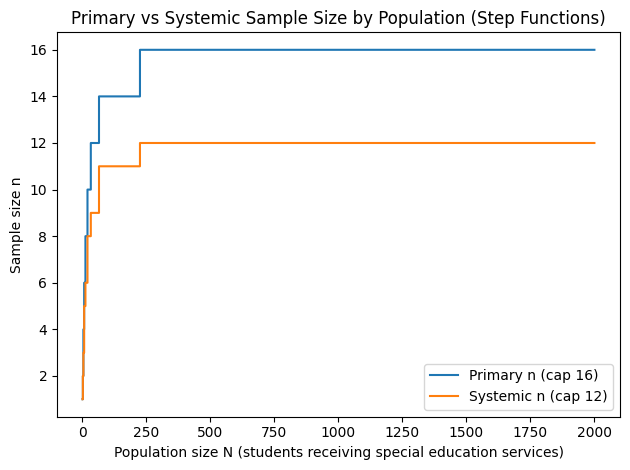

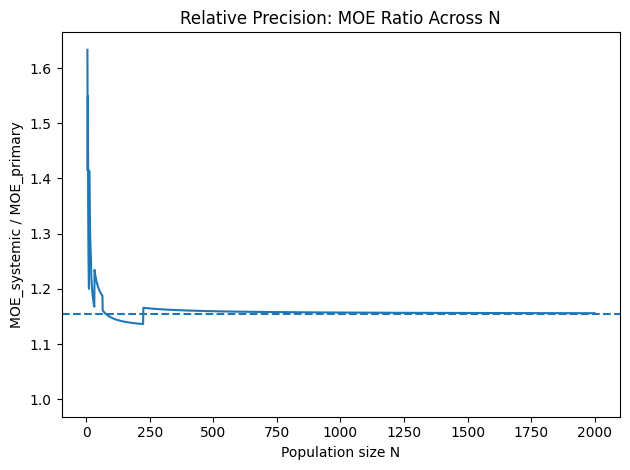

In [7]:
# Step curves
N_max = 2000
Ns = np.arange(1, N_max + 1)
primary_vec  = np.array([primary_n_for_N(int(N)) for N in Ns])
systemic_vec = np.array([systemic_n_from_primary(n) for n in primary_vec])

plt.figure()
plt.step(Ns, primary_vec, where="post", label="Primary n (cap 16)")
plt.step(Ns, systemic_vec, where="post", label="Systemic n (cap 12)")
plt.xlabel("Population size N (students receiving special education services)")
plt.ylabel("Sample size n")
plt.title("Primary vs Systemic Sample Size by Population (Step Functions)")
plt.legend(loc="best")
plt.tight_layout()
buf_step = io.BytesIO()
plt.savefig(buf_step, format="png", dpi=200)
buf_step.seek(0)

# MOE ratio
moe_ratios = [moe_ratio(int(N),
                        primary_n_for_N(int(N)),
                        systemic_n_from_primary(primary_n_for_N(int(N))))
              for N in Ns]
plt.figure()
plt.plot(Ns, moe_ratios)
plt.axhline(y=math.sqrt(1.0/0.75), linestyle="--")
plt.xlabel("Population size N")
plt.ylabel("MOE_systemic / MOE_primary")
plt.title("Relative Precision: MOE Ratio Across N")
plt.tight_layout()
buf_moe = io.BytesIO()
plt.savefig(buf_moe, format="png", dpi=200)
buf_moe.seek(0)


### 6. Excel export

Creates an `.xlsx` workbook with:
- **Parameters**
- **Primary_Table**
- **Systemic_Table**
- **Production_Rubric**
- **Figures** sheet embedding both PNG charts


In [15]:
# 1. Install xlsxwriter (only once per runtime session)
!pip install xlsxwriter

# 2. No need for this line in Colab — pandas already provides ExcelWriter:
# from pandas import ExcelWriter

# 3. Use ExcelWriter with the xlsxwriter engine
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:

  ts = datetime.now().strftime("%Y%m%d_%H%M%S")
  excel_path = f"/content/Systemic_Sample_Size_Tables_and_Figures_{ts}.xlsx"

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    # Parameters sheet
    pd.DataFrame({
        "Parameter": ["RATIO_SYSTEMIC", "PRIMARY_CAP", "SYSTEMIC_CAP", "Z (ref)", "P (ref)"],
        "Value": [RATIO_SYSTEMIC, PRIMARY_CAP, SYSTEMIC_CAP, 1.96, 0.5]
    }).to_excel(writer, index=False, sheet_name="Parameters")

    # Tables
    primary_ref_df.to_excel(writer, index=False, sheet_name="Primary_Table")
    systemic_map_df.to_excel(writer, index=False, sheet_name="Systemic_Table")
    rubric_df.to_excel(writer, index=False, sheet_name="Production_Rubric")

    # Figures sheet with embedded images
    wb  = writer.book
    ws  = wb.add_worksheet("Figures")
    writer.sheets["Figures"] = ws
    title_fmt = wb.add_format({"bold": True, "font_size": 12})

    ws.write(0, 0, "Figure 1. Primary vs Systemic Sample Size by Population", title_fmt)
    ws.insert_image(1, 0, "fig_step.png", {"image_data": buf_step, "x_scale": 1.0, "y_scale": 1.0})

    ws.write(36, 0, "Figure 2. Relative Precision: MOE Ratio Across N", title_fmt)
    ws.insert_image(37, 0, "fig_moe.png", {"image_data": buf_moe, "x_scale": 1.0, "y_scale": 1.0})

print("Workbook written:", excel_path)

# Optional: save the two figures as standalone PNGs for slides
with open("/content/Figure1_Primary_vs_Systemic.png", "wb") as f:
    f.write(buf_step.getbuffer())
with open("/content/Figure2_MOE_Ratio.png", "wb") as f:
    f.write(buf_moe.getbuffer())

print("Figure 1:", "/content/Figure1_Primary_vs_Systemic.png")
print("Figure 2:", "/content/Figure2_MOE_Ratio.png")


Workbook written: /content/Systemic_Sample_Size_Tables_and_Figures_20250831_101356.xlsx
Figure 1: /content/Figure1_Primary_vs_Systemic.png
Figure 2: /content/Figure2_MOE_Ratio.png


Use these only if you want Colab to pop downloads in your browser (commented by default in code cells).


In [16]:
from google.colab import files
files.download(excel_path)
files.download("/content/Figure1_Primary_vs_Systemic.png")
files.download("/content/Figure2_MOE_Ratio.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 7. Math recap

**Primary MOE with FPC**
![MOE](https://latex.codecogs.com/svg.latex?MOE%20%5Capprox%20Z%20%5Ctimes%20%5Csqrt%7B%5Cfrac%7Bp%281-p%29%7D%7Bn%7D%7D%20%5Ctimes%20%5Csqrt%7B%5Cfrac%7BN-n%7D%7BN-1%7D%7D)

**Primary n (reference)**
![n](https://latex.codecogs.com/svg.latex?n%20=%20%5Cfrac%7BNZ%5E2p%281-p%29%7D%7B%28N-1%29e%5E2%20+%20Z%5E2p%281-p%29%7D)

**Systemic rule**
![sys](https://latex.codecogs.com/svg.latex?n_%7Bsys%7D%28N%29%20=%20%5Cmin%2812,%20%5Clceil0.75%20%5Ccdot%20n_%7Bprimary%7D%28N%29%5Crceil%29)

**Precision change**
![ratio](https://latex.codecogs.com/svg.latex?%5Cfrac%7BMOE_%7Bsys%7D%7D%7BMOE_%7Bprim%7D%7D%20%5Capprox%20%5Csqrt%7B1/0.75%7D%20%5Capprox%201.155)


Primary reference (N → primary):


,SPED population (N),Primary n (cap 16)
0,1–1,1
1,2–3,2
2,4–6,4
3,7–11,6
4,12–19,8
5,20–32,10
6,33–64,12
7,65–224,14
8,225+,16



Primary → Systemic (with Census rule):


,Primary n,ceil(0.75 * n) (capped 12),Systemic requirement
0,1,1,Census
1,2,2,Census
2,4,3,Census
3,6,5,Census
4,8,6,Census
5,10,8,Census
6,12,9,9
7,14,11,11
8,16,12,12



Combined mapping (N → primary → systemic/census):


,SPED population (N),Primary n,Systemic requirement
0,1–1,1,Census
1,2–3,2,Census
2,4–6,4,Census
3,7–11,6,Census
4,12–19,8,Census
5,20–32,10,Census
6,33–64,12,9
7,65–224,14,11
8,225+,16,12



Policy quick reference (bands):


,Band,Systemic requirement
0,<9 students,Census
1,9–49,9
2,50–100,11
3,101–500,12
4,501–1500,12
5,>1500,12



Generated Figure 1: Primary vs Systemic (step functions)
Generated Figure 2: MOE ratio curve
Saved figure PNGs to /content/

Workbook written: /content/Systemic_Sample_Size_Tables_and_Figures_20250831_102128.xlsx
Figure 1: /content/Figure1_Primary_vs_Systemic.png
Figure 2: /content/Figure2_MOE_Ratio.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

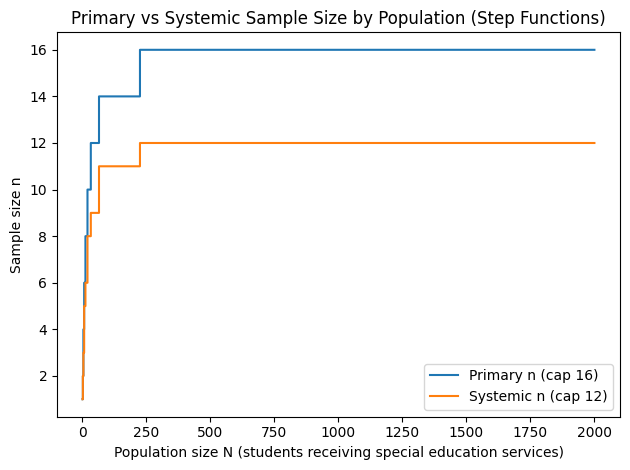

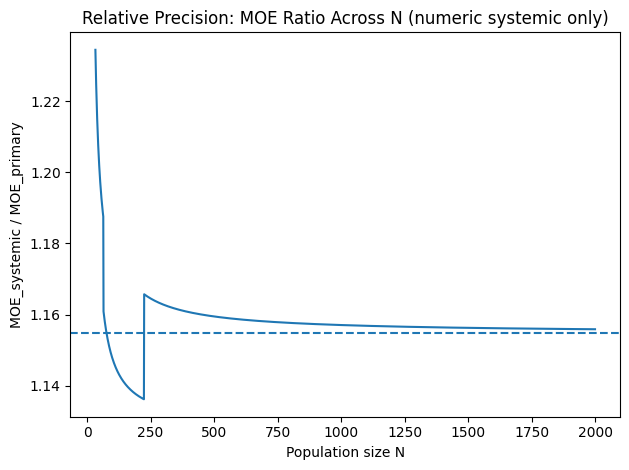

In [17]:
# ============================================================
# TEA — Systemic Sample Size Generator (Cap 12) — Colab Script
# ============================================================
# What this produces:
#  1) N → Primary mapping (approved post-hoc table; cap = 16)
#  2) Primary → Systemic mapping (n_sys = ceil(0.75 * n_primary), cap = 12)
#     + Census rule: if n_sys < 9, require "Census" (all folders)
#  3) Combined mapping (N → Primary → Systemic/Census)
#  4) Policy quick-reference table (simple band view)
#  5) Figures:
#       - Step functions: Primary vs Systemic by population
#       - MOE ratio curve: MOE_sys / MOE_prim (numeric-sys only)
#  6) Excel workbook with all tables + embedded figures
#
# Notes:
# - Matplotlib only (no seaborn); one chart per figure; no explicit colors
# - Excel image embedding requires xlsxwriter, installed below

# ---------- Setup ----------
!pip install -q xlsxwriter

import math, io
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Parameters ----------
RATIO_SYSTEMIC   = 0.75            # systemic = ceil(0.75 * primary)
PRIMARY_CAP      = 16              # approved cap from post-hoc table
SYSTEMIC_CAP     = math.ceil(RATIO_SYSTEMIC * PRIMARY_CAP)  # -> 12
CENSUS_THRESHOLD = 9               # if systemic < 9 ⇒ Census
Z                = 1.96            # reference only (cancels in MOE ratio)
P                = 0.5             # reference only (cancels in MOE ratio)

# Approved Primary (post-hoc) table as stepwise ranges -> n (cap 16)
PRIMARY_TABLE_RANGES = [
    {"lo": 1,   "hi": 1,    "n": 1},
    {"lo": 2,   "hi": 3,    "n": 2},
    {"lo": 4,   "hi": 6,    "n": 4},
    {"lo": 7,   "hi": 11,   "n": 6},
    {"lo": 12,  "hi": 19,   "n": 8},
    {"lo": 20,  "hi": 32,   "n": 10},
    {"lo": 33,  "hi": 64,   "n": 12},
    {"lo": 65,  "hi": 224,  "n": 14},
    {"lo": 225, "hi": None, "n": 16},  # 225+
]

# Communication bands for (optional) policy quick reference
POLICY_BANDS = [
    {"label": "<9 students", "rule": "Census"},
    {"label": "9–49",        "rule": 9},
    {"label": "50–100",      "rule": 11},
    {"label": "101–500",     "rule": 12},
    {"label": "501–1500",    "rule": 12},
    {"label": ">1500",       "rule": 12},
]

# ---------- Helper functions ----------
def primary_n_for_N(N: int) -> int:
    """Look up primary sample size for population N."""
    for row in PRIMARY_TABLE_RANGES:
        lo, hi, n = row["lo"], row["hi"], row["n"]
        if hi is None:
            if N >= lo:
                return n
        else:
            if lo <= N <= hi:
                return n
    return PRIMARY_CAP  # fallback

def systemic_n_from_primary_numeric(n_primary: int) -> int:
    """Numeric systemic n (with cap) without applying the census label."""
    return min(math.ceil(RATIO_SYSTEMIC * n_primary), SYSTEMIC_CAP)

def systemic_label_from_primary(n_primary: int):
    """
    Systemic requirement with census rule applied.
    Returns 'Census' if systemic < CENSUS_THRESHOLD, else the numeric systemic n.
    """
    n_sys = systemic_n_from_primary_numeric(n_primary)
    if n_sys < CENSUS_THRESHOLD:
        return "Census"
    return n_sys

def moe_ratio(N: int, n_primary: int, n_systemic_numeric: int) -> float:
    """
    MOE_systemic / MOE_primary under SRS with FPC.
    Use only when systemic is numeric (not Census).
    MOE ~ sqrt(p(1-p)/n) * sqrt((N-n)/(N-1)) * Z, so constants cancel.
    """
    if n_systemic_numeric <= 0 or (N - n_primary) <= 0:
        return float("nan")
    return float(
        math.sqrt(n_primary / n_systemic_numeric) *
        math.sqrt((N - n_systemic_numeric) / (N - n_primary))
    )

# ---------- Tables ----------
# A) Primary reference: stepwise ranges
primary_ref_df = pd.DataFrame([
    {"SPED population (N)": (f"{r['lo']}+" if r["hi"] is None else f"{r['lo']}–{r['hi']}"),
     "Primary n (cap 16)": r["n"]}
    for r in PRIMARY_TABLE_RANGES
])

# B) Primary → Systemic mapping (with census rule)
primary_values = [1, 2, 4, 6, 8, 10, 12, 14, 16]
primary_to_systemic_df = pd.DataFrame([
    {
        "Primary n": n,
        "ceil(0.75 * n) (capped 12)": systemic_n_from_primary_numeric(n),
        "Systemic requirement": systemic_label_from_primary(n)
    }
    for n in primary_values
])

# C) Combined mapping: N → Primary → Systemic/Census (as ranges)
combined_mapping_df = pd.DataFrame([
    {
        "SPED population (N)": (f"{r['lo']}+" if r["hi"] is None else f"{r['lo']}–{r['hi']}"),
        "Primary n": r["n"],
        "Systemic requirement": systemic_label_from_primary(r["n"])
    }
    for r in PRIMARY_TABLE_RANGES
])

# D) Policy quick reference (simple band view, optional)
policy_quick_reference_df = pd.DataFrame([
    {"Band": b["label"], "Systemic requirement": b["rule"]} for b in POLICY_BANDS
])

# Display key tables in the notebook
print("Primary reference (N → primary):")
display(primary_ref_df)
print("\nPrimary → Systemic (with Census rule):")
display(primary_to_systemic_df)
print("\nCombined mapping (N → primary → systemic/census):")
display(combined_mapping_df)
print("\nPolicy quick reference (bands):")
display(policy_quick_reference_df)

# ---------- Visualizations ----------
# 1) Step functions: Primary vs Systemic by N
N_max = 2000
Ns = np.arange(1, N_max + 1)
primary_vec  = np.array([primary_n_for_N(int(N)) for N in Ns])
systemic_vec = np.array([systemic_n_from_primary_numeric(n) for n in primary_vec])

plt.figure()
plt.step(Ns, primary_vec, where="post", label="Primary n (cap 16)")
plt.step(Ns, systemic_vec, where="post", label="Systemic n (cap 12)")
plt.xlabel("Population size N (students receiving special education services)")
plt.ylabel("Sample size n")
plt.title("Primary vs Systemic Sample Size by Population (Step Functions)")
plt.legend(loc="best")
plt.tight_layout()
buf_step = io.BytesIO()
plt.savefig(buf_step, format="png", dpi=200)
buf_step.seek(0)
print("\nGenerated Figure 1: Primary vs Systemic (step functions)")

# 2) MOE ratio curve (numeric systemic only)
moe_ratios = []
for N in Ns:
    n_p = primary_n_for_N(int(N))
    n_s_numeric = systemic_n_from_primary_numeric(n_p)
    if n_s_numeric < CENSUS_THRESHOLD:
        moe_ratios.append(np.nan)  # not defined for Census; skip
    else:
        moe_ratios.append(moe_ratio(int(N), n_p, n_s_numeric))
moe_ratios = np.array(moe_ratios)

plt.figure()
plt.plot(Ns, moe_ratios)
plt.axhline(y=math.sqrt(1.0 / RATIO_SYSTEMIC), linestyle="--")  # ~1.1547
plt.xlabel("Population size N")
plt.ylabel("MOE_systemic / MOE_primary")
plt.title("Relative Precision: MOE Ratio Across N (numeric systemic only)")
plt.tight_layout()
buf_moe = io.BytesIO()
plt.savefig(buf_moe, format="png", dpi=200)
buf_moe.seek(0)
print("Generated Figure 2: MOE ratio curve")

# Also save figures as standalone PNGs (useful for slides)
with open("/content/Figure1_Primary_vs_Systemic.png", "wb") as f:
    f.write(buf_step.getbuffer())
with open("/content/Figure2_MOE_Ratio.png", "wb") as f:
    f.write(buf_moe.getbuffer())
print("Saved figure PNGs to /content/")

# ---------- Excel export ----------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_path = f"/content/Systemic_Sample_Size_Tables_and_Figures_{ts}.xlsx"

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    # Parameters
    pd.DataFrame({
        "Parameter": ["RATIO_SYSTEMIC", "PRIMARY_CAP", "SYSTEMIC_CAP", "CENSUS_THRESHOLD", "Z (ref)", "P (ref)"],
        "Value": [RATIO_SYSTEMIC, PRIMARY_CAP, SYSTEMIC_CAP, CENSUS_THRESHOLD, Z, P]
    }).to_excel(writer, index=False, sheet_name="Parameters")

    # Core mappings
    primary_ref_df.to_excel(writer, index=False, sheet_name="N_to_Primary")
    primary_to_systemic_df.to_excel(writer, index=False, sheet_name="Primary_to_Systemic")
    combined_mapping_df.to_excel(writer, index=False, sheet_name="Combined_Mapping")

    # Policy quick reference
    policy_quick_reference_df.to_excel(writer, index=False, sheet_name="Policy_Quick_Reference")

    # Figures sheet with embedded images
    wb  = writer.book
    ws  = wb.add_worksheet("Figures")
    writer.sheets["Figures"] = ws
    title_fmt = wb.add_format({"bold": True, "font_size": 12})

    ws.write(0, 0, "Figure 1. Primary vs Systemic Sample Size by Population", title_fmt)
    ws.insert_image(1, 0, "fig_step.png", {"image_data": buf_step, "x_scale": 1.0, "y_scale": 1.0})

    ws.write(36, 0, "Figure 2. Relative Precision: MOE Ratio Across N", title_fmt)
    ws.insert_image(37, 0, "fig_moe.png", {"image_data": buf_moe, "x_scale": 1.0, "y_scale": 1.0})

print("\nWorkbook written:", excel_path)
print("Figure 1:", "/content/Figure1_Primary_vs_Systemic.png")
print("Figure 2:", "/content/Figure2_MOE_Ratio.png")

# ---------- (Optional) One-click downloads ----------
from google.colab import files
files.download(excel_path)
files.download("/content/Figure1_Primary_vs_Systemic.png")
files.download("/content/Figure2_MOE_Ratio.png")


Primary reference (N → primary):


,SPED population (N),Primary n (cap 16)
0,1–1,1
1,2–3,2
2,4–6,4
3,7–11,6
4,12–19,8
5,20–32,10
6,33–64,12
7,65–224,14
8,225+,16



Primary → Systemic (with Census rule):


,Primary n,ceil(0.75 * n) (capped 12),Systemic requirement
0,1,1,Census
1,2,2,Census
2,4,3,Census
3,6,5,Census
4,8,6,Census
5,10,8,Census
6,12,9,9
7,14,11,11
8,16,12,12



Combined mapping (N → primary → systemic/census):


,SPED population (N),Primary n,Systemic requirement
0,1–1,1,Census
1,2–3,2,Census
2,4–6,4,Census
3,7–11,6,Census
4,12–19,8,Census
5,20–32,10,Census
6,33–64,12,9
7,65–224,14,11
8,225+,16,12



Policy quick reference (bands):


,Band,Systemic requirement
0,<9 students,Census
1,9–49,9
2,50–100,11
3,101–500,12
4,501–1500,12
5,>1500,12



Generated Figure 1: Primary vs Systemic (step functions)
Generated Figure 2: MOE ratio curve
Generated Figure 3: Step functions with Census regions highlighted
Saved figure PNGs to /content/

Workbook written: /content/Systemic_Sample_Size_Tables_and_Figures_20250831_102606.xlsx
Figure 1: /content/Figure1_Primary_vs_Systemic.png
Figure 2: /content/Figure2_MOE_Ratio.png
Figure 3: /content/Figure3_Census_Regions.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

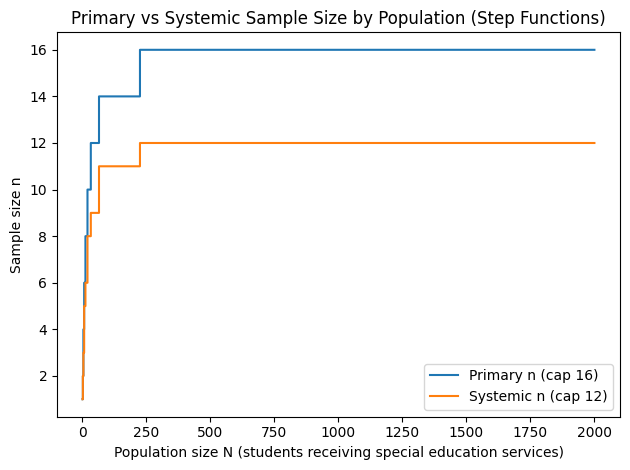

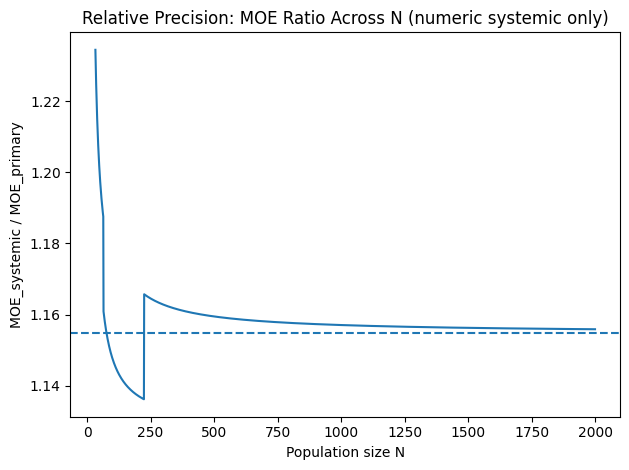

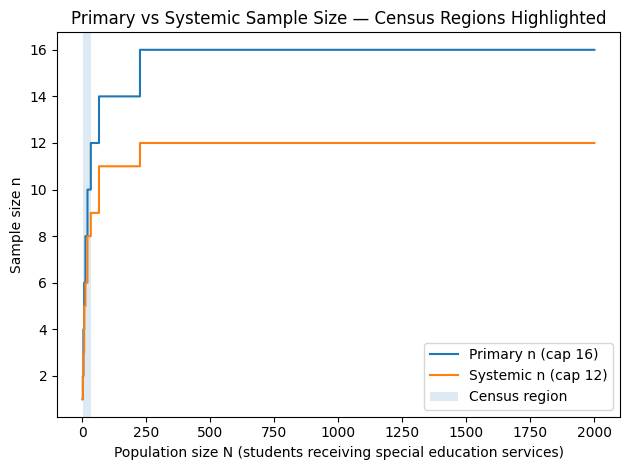

In [18]:
# ============================================================
# TEA — Systemic Sample Size Generator (Cap 12) — Colab Script
# ============================================================
# Produces:
#  1) N → Primary mapping (approved post-hoc table; cap = 16)
#  2) Primary → Systemic mapping (n_sys = ceil(0.75 * n_primary), cap = 12)
#     + Census rule: if n_sys < 9, require "Census" (all folders)
#  3) Combined mapping (N → Primary → Systemic/Census)
#  4) Policy quick-reference table (simple band view)
#  5) Figures:
#       - Fig 1: Step functions — Primary vs Systemic by population
#       - Fig 2: MOE ratio curve — MOE_sys / MOE_prim (numeric systemic only)
#       - Fig 3: Step functions with Census regions highlighted
#  6) Excel workbook with all tables + embedded figures

# ---------- Setup ----------
!pip install -q xlsxwriter

import math, io
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- Parameters ----------
RATIO_SYSTEMIC   = 0.75            # systemic = ceil(0.75 * primary)
PRIMARY_CAP      = 16              # approved cap from post-hoc table
SYSTEMIC_CAP     = math.ceil(RATIO_SYSTEMIC * PRIMARY_CAP)  # -> 12
CENSUS_THRESHOLD = 9               # if systemic < 9 ⇒ Census
Z                = 1.96            # reference only (cancels in MOE ratio)
P                = 0.5             # reference only (cancels in MOE ratio)

# Approved Primary (post-hoc) table as stepwise ranges -> n (cap 16)
PRIMARY_TABLE_RANGES = [
    {"lo": 1,   "hi": 1,    "n": 1},
    {"lo": 2,   "hi": 3,    "n": 2},
    {"lo": 4,   "hi": 6,    "n": 4},
    {"lo": 7,   "hi": 11,   "n": 6},
    {"lo": 12,  "hi": 19,   "n": 8},
    {"lo": 20,  "hi": 32,   "n": 10},
    {"lo": 33,  "hi": 64,   "n": 12},
    {"lo": 65,  "hi": 224,  "n": 14},
    {"lo": 225, "hi": None, "n": 16},  # 225+
]

# Communication bands for (optional) policy quick reference
POLICY_BANDS = [
    {"label": "<9 students", "rule": "Census"},
    {"label": "9–49",        "rule": 9},
    {"label": "50–100",      "rule": 11},
    {"label": "101–500",     "rule": 12},
    {"label": "501–1500",    "rule": 12},
    {"label": ">1500",       "rule": 12},
]

# ---------- Helper functions ----------
def primary_n_for_N(N: int) -> int:
    """Look up primary sample size for population N."""
    for row in PRIMARY_TABLE_RANGES:
        lo, hi, n = row["lo"], row["hi"], row["n"]
        if hi is None:
            if N >= lo:
                return n
        else:
            if lo <= N <= hi:
                return n
    return PRIMARY_CAP  # fallback

def systemic_n_from_primary_numeric(n_primary: int) -> int:
    """Numeric systemic n (with cap) without applying the census label."""
    return min(math.ceil(RATIO_SYSTEMIC * n_primary), SYSTEMIC_CAP)

def systemic_label_from_primary(n_primary: int):
    """
    Systemic requirement with census rule applied.
    Returns 'Census' if systemic < CENSUS_THRESHOLD, else the numeric systemic n.
    """
    n_sys = systemic_n_from_primary_numeric(n_primary)
    if n_sys < CENSUS_THRESHOLD:
        return "Census"
    return n_sys

def moe_ratio(N: int, n_primary: int, n_systemic_numeric: int) -> float:
    """
    MOE_systemic / MOE_primary under SRS with FPC.
    Use only when systemic is numeric (not Census).
    MOE ~ sqrt(p(1-p)/n) * sqrt((N-n)/(N-1)) * Z, so constants cancel.
    """
    if n_systemic_numeric <= 0 or (N - n_primary) <= 0:
        return float("nan")
    return float(
        math.sqrt(n_primary / n_systemic_numeric) *
        math.sqrt((N - n_systemic_numeric) / (N - n_primary))
    )

# ---------- Tables ----------
# A) Primary reference: stepwise ranges
primary_ref_df = pd.DataFrame([
    {"SPED population (N)": (f"{r['lo']}+" if r["hi"] is None else f"{r['lo']}–{r['hi']}"),
     "Primary n (cap 16)": r["n"]}
    for r in PRIMARY_TABLE_RANGES
])

# B) Primary → Systemic mapping (with census rule)
primary_values = [1, 2, 4, 6, 8, 10, 12, 14, 16]
primary_to_systemic_df = pd.DataFrame([
    {
        "Primary n": n,
        "ceil(0.75 * n) (capped 12)": systemic_n_from_primary_numeric(n),
        "Systemic requirement": systemic_label_from_primary(n)
    }
    for n in primary_values
])

# C) Combined mapping: N → Primary → Systemic/Census (as ranges)
combined_mapping_df = pd.DataFrame([
    {
        "SPED population (N)": (f"{r['lo']}+" if r["hi"] is None else f"{r['lo']}–{r['hi']}"),
        "Primary n": r["n"],
        "Systemic requirement": systemic_label_from_primary(r["n"])
    }
    for r in PRIMARY_TABLE_RANGES
])

# D) Policy quick reference (simple band view, optional)
policy_quick_reference_df = pd.DataFrame([
    {"Band": b["label"], "Systemic requirement": b["rule"]} for b in POLICY_BANDS
])

# Display key tables in the notebook
print("Primary reference (N → primary):")
display(primary_ref_df)
print("\nPrimary → Systemic (with Census rule):")
display(primary_to_systemic_df)
print("\nCombined mapping (N → primary → systemic/census):")
display(combined_mapping_df)
print("\nPolicy quick reference (bands):")
display(policy_quick_reference_df)

# ---------- Visualizations ----------
# Precompute sequences for plotting
N_max = 2000
Ns = np.arange(1, N_max + 1)
primary_vec  = np.array([primary_n_for_N(int(N)) for N in Ns])
systemic_vec = np.array([systemic_n_from_primary_numeric(n) for n in primary_vec])

# Fig 1: Step functions — Primary vs Systemic
plt.figure()
plt.step(Ns, primary_vec, where="post", label="Primary n (cap 16)")
plt.step(Ns, systemic_vec, where="post", label="Systemic n (cap 12)")
plt.xlabel("Population size N (students receiving special education services)")
plt.ylabel("Sample size n")
plt.title("Primary vs Systemic Sample Size by Population (Step Functions)")
plt.legend(loc="best")
plt.tight_layout()
buf_step = io.BytesIO()
plt.savefig(buf_step, format="png", dpi=200)
buf_step.seek(0)
print("\nGenerated Figure 1: Primary vs Systemic (step functions)")

# Fig 2: MOE ratio curve (numeric systemic only)
moe_ratios = []
for N in Ns:
    n_p = primary_n_for_N(int(N))
    n_s_numeric = systemic_n_from_primary_numeric(n_p)
    if n_s_numeric < CENSUS_THRESHOLD:
        moe_ratios.append(np.nan)  # not defined for Census; skip
    else:
        moe_ratios.append(moe_ratio(int(N), n_p, n_s_numeric))
moe_ratios = np.array(moe_ratios)

plt.figure()
plt.plot(Ns, moe_ratios)
plt.axhline(y=math.sqrt(1.0 / RATIO_SYSTEMIC), linestyle="--")  # ~1.1547
plt.xlabel("Population size N")
plt.ylabel("MOE_systemic / MOE_primary")
plt.title("Relative Precision: MOE Ratio Across N (numeric systemic only)")
plt.tight_layout()
buf_moe = io.BytesIO()
plt.savefig(buf_moe, format="png", dpi=200)
buf_moe.seek(0)
print("Generated Figure 2: MOE ratio curve")

# Fig 3: Step functions with Census regions highlighted (systemic < 9)
census_mask = systemic_vec < CENSUS_THRESHOLD
edges = np.diff(census_mask.astype(int))
starts = list(np.where(edges == 1)[0] + 1)
ends   = list(np.where(edges == -1)[0] + 1)
if census_mask[0]:
    starts = [0] + starts
if census_mask[-1]:
    ends = ends + [len(census_mask)]

plt.figure()
plt.step(Ns, primary_vec, where="post", label="Primary n (cap 16)")
plt.step(Ns, systemic_vec, where="post", label="Systemic n (cap 12)")
ax = plt.gca()
for idx, (s, e) in enumerate(zip(starts, ends)):
    ax.axvspan(Ns[s], Ns[e-1], alpha=0.15, label="Census region" if idx == 0 else None)

plt.xlabel("Population size N (students receiving special education services)")
plt.ylabel("Sample size n")
plt.title("Primary vs Systemic Sample Size — Census Regions Highlighted")
plt.legend(loc="best")
plt.tight_layout()
buf_census = io.BytesIO()
plt.savefig(buf_census, format="png", dpi=200)
buf_census.seek(0)
print("Generated Figure 3: Step functions with Census regions highlighted")

# Save figures as standalone PNGs (useful for slides)
with open("/content/Figure1_Primary_vs_Systemic.png", "wb") as f:
    f.write(buf_step.getbuffer())
with open("/content/Figure2_MOE_Ratio.png", "wb") as f:
    f.write(buf_moe.getbuffer())
with open("/content/Figure3_Census_Regions.png", "wb") as f:
    f.write(buf_census.getbuffer())
print("Saved figure PNGs to /content/")

# ---------- Excel export ----------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_path = f"/content/Systemic_Sample_Size_Tables_and_Figures_{ts}.xlsx"

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    # Parameters
    pd.DataFrame({
        "Parameter": ["RATIO_SYSTEMIC", "PRIMARY_CAP", "SYSTEMIC_CAP", "CENSUS_THRESHOLD", "Z (ref)", "P (ref)"],
        "Value": [RATIO_SYSTEMIC, PRIMARY_CAP, SYSTEMIC_CAP, CENSUS_THRESHOLD, Z, P]
    }).to_excel(writer, index=False, sheet_name="Parameters")

    # Core mappings
    primary_ref_df.to_excel(writer, index=False, sheet_name="N_to_Primary")
    primary_to_systemic_df.to_excel(writer, index=False, sheet_name="Primary_to_Systemic")
    combined_mapping_df.to_excel(writer, index=False, sheet_name="Combined_Mapping")

    # Policy quick reference
    policy_quick_reference_df.to_excel(writer, index=False, sheet_name="Policy_Quick_Reference")

    # Figures sheet with embedded images
    wb  = writer.book
    ws  = wb.add_worksheet("Figures")
    writer.sheets["Figures"] = ws
    title_fmt = wb.add_format({"bold": True, "font_size": 12})

    ws.write(0, 0, "Figure 1. Primary vs Systemic Sample Size by Population", title_fmt)
    ws.insert_image(1, 0, "fig_step.png", {"image_data": buf_step, "x_scale": 1.0, "y_scale": 1.0})

    ws.write(36, 0, "Figure 2. Relative Precision: MOE Ratio Across N", title_fmt)
    ws.insert_image(37, 0, "fig_moe.png", {"image_data": buf_moe, "x_scale": 1.0, "y_scale": 1.0})

    ws.write(71, 0, "Figure 3. Primary vs Systemic with Census Regions Highlighted", title_fmt)
    ws.insert_image(72, 0, "fig_census.png", {"image_data": buf_census, "x_scale": 1.0, "y_scale": 1.0})

print("\nWorkbook written:", excel_path)
print("Figure 1:", "/content/Figure1_Primary_vs_Systemic.png")
print("Figure 2:", "/content/Figure2_MOE_Ratio.png")
print("Figure 3:", "/content/Figure3_Census_Regions.png")

# ---------- (Optional) One-click downloads ----------
from google.colab import files
files.download(excel_path)
files.download("/content/Figure1_Primary_vs_Systemic.png")
files.download("/content/Figure2_MOE_Ratio.png")
files.download("/content/Figure3_Census_Regions.png")
